<h1>DL Test </h1>

In [ ]:
import pandas as pd
# Import de la data avec un certain nombre d'avis par classe
df = pd.read_csv('data/original.csv')
max_per_class = 10_000
batch_size = 32
for rating in range(1,6):
    df_rating = df[df['rating'] == rating]
    if len(df_rating) > max_per_class:
        df = df.drop(df_rating.index[max_per_class:])

C:\Users\Steffen\AppData\Local\Temp\ipykernel_16164\3962563179.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reviews_FINAL.csv')


In [ ]:
# Ajout tu paramètre day_diff
df["day_diff"] = pd.to_datetime(df["dates.publishedDate"]) - pd.to_datetime(df["dates.experiencedDate"])
df["day_diff"] = df["day_diff"].dt.days.fillna(0) # remplacement des nan (pas de date d'expérience) par 0.
df = df[["rating", "text", "day_diff"]]

In [22]:
df.head()
df.columns

Index(['rating', 'text', 'day_diff'], dtype='object')

<h2>Création du modèle</h2>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


class ReviewDataset(Dataset):
    def __init__(self, texts, metadata, labels, tokenizer, max_len=128):
        self.texts = texts
        self.metadata = metadata
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        metadata = torch.tensor(self.metadata[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'metadata': metadata,
            'label': label
        }


class BERTWithMetadata(nn.Module):
    def __init__(self, bert_model_name, metadata_dim, hidden_dim=128, num_classes=1):
        super(BERTWithMetadata, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name) # Init du modèle Bert
        self.metadata_fc = nn.Linear(metadata_dim, hidden_dim) # Couche linéaire pour les métadonnées
        self.fc1 = nn.Linear(self.bert.config.hidden_size + hidden_dim, hidden_dim) # Combinaison Bert + Métadonnées
        self.fc2 = nn.Linear(hidden_dim, num_classes) # Transformation finale vers la prédiction
        self.dropout = nn.Dropout(0.3) # Dropout de 30% contre l'overfitting
        self.relu = nn.ReLU() # Fonction d'activation ReLU
        
    def forward(self, input_ids, attention_mask, metadata):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output
        
        metadata_features = self.relu(self.metadata_fc(metadata))
        
        combined = torch.cat((text_features, metadata_features), dim=1)
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output


def train_model(texts, metadata, labels, tokenizer):

    
    dataset = ReviewDataset(texts, metadata, labels, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithMetadata("bert-base-uncased", metadata_dim=1).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    
    model.train()
    for epoch in range(3):
        # torch.cuda.empty_cache()
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return(model)



In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[["text", "day_diff"]], df["rating"], test_size=0.2, random_state=42)

In [25]:
if torch.cuda.is_available():
    print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire totale : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Mémoire libre : {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Mémoire réservée : {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
else:
    print("CUDA n'est pas disponible.")
torch.cuda.empty_cache()

Nom du GPU : NVIDIA GeForce GTX 1050
Mémoire totale : 2.00 GB
Mémoire libre : 0.85 GB
Mémoire réservée : 3.92 GB


<h2>Entraînement du modèle</h2>

In [26]:
model = train_model(x_train["text"].values, x_train[["day_diff"]].values, y_train.values, tokenizer)

Epoch 1, Loss: 10.7776
Epoch 1, Loss: 20.9488
Epoch 1, Loss: 6.6042
Epoch 1, Loss: 12.8894
Epoch 1, Loss: 8.7432
Epoch 1, Loss: 20.6125
Epoch 1, Loss: 12.4476
Epoch 1, Loss: 4.3033
Epoch 1, Loss: 15.6991
Epoch 1, Loss: 18.1527
Epoch 1, Loss: 7.1541
Epoch 1, Loss: 6.9903
Epoch 1, Loss: 4.6845
Epoch 1, Loss: 7.4447
Epoch 1, Loss: 6.7890
Epoch 1, Loss: 1.2371
Epoch 1, Loss: 9.8736
Epoch 1, Loss: 10.7184
Epoch 1, Loss: 6.0495
Epoch 1, Loss: 13.5554
Epoch 1, Loss: 15.7307
Epoch 1, Loss: 4.0638
Epoch 1, Loss: 0.1159
Epoch 1, Loss: 5.2148
Epoch 1, Loss: 14.1007
Epoch 1, Loss: 14.9731
Epoch 1, Loss: 15.5833
Epoch 1, Loss: 4.9498
Epoch 1, Loss: 0.1111
Epoch 1, Loss: 3.9053
Epoch 1, Loss: 2.7658
Epoch 1, Loss: 0.5077
Epoch 1, Loss: 8.3413
Epoch 1, Loss: 5.3046
Epoch 1, Loss: 5.9276
Epoch 1, Loss: 7.8239
Epoch 1, Loss: 0.7404
Epoch 1, Loss: 0.6293
Epoch 1, Loss: 0.6216
Epoch 1, Loss: 7.3384
Epoch 1, Loss: 7.0892
Epoch 1, Loss: 2.4000
Epoch 1, Loss: 5.7469
Epoch 1, Loss: 1.6617
Epoch 1, Loss: 5.92

<h2>Prédiction sur la donnée de test</h2>

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def test_model(model, test_texts, test_metadata, test_labels, tokenizer, batch_size=32, max_len=128):
    
    test_dataset = ReviewDataset(test_texts, test_metadata, test_labels, tokenizer, max_len=max_len)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            
            # Prédictions
            outputs = model(input_ids, attention_mask, metadata)
            
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())


    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    mse = mean_squared_error(all_labels, all_preds)
    print(f'Mean Squared Error (MSE) on the test set: {mse:.4f}')
    
    # Affichagte de quelques prédictions pour vérifier
    for i in range(5):
        print(f"Predicted: {all_preds[i].item()}, Actual: {all_labels[i].item()}")
    return(all_preds)

In [ ]:
# Génération des prédictions de test.
all_preds = test_model(model, x_test["text"].values, x_test[["day_diff"]].values, y_test.values, tokenizer)

Mean Squared Error (MSE) on the test set: 0.7641
Predicted: 2.1726930141448975, Actual: 3.0
Predicted: 1.4505378007888794, Actual: 3.0
Predicted: 1.7523471117019653, Actual: 3.0
Predicted: 4.429790019989014, Actual: 5.0
Predicted: 3.9423065185546875, Actual: 4.0


In [29]:
# Charger le modèle pré-entrainé et l'utiliser pour faire des prédictions sur les données de test
all_preds_train = test_model(model, x_train["text"].values, x_train[["day_diff"]].values, y_train.values, tokenizer)

Mean Squared Error (MSE) on the test set: 0.4274
Predicted: 4.686326503753662, Actual: 5.0
Predicted: 4.1908063888549805, Actual: 4.0
Predicted: 4.55457878112793, Actual: 4.0
Predicted: 4.5951642990112305, Actual: 5.0
Predicted: 1.4584507942199707, Actual: 1.0


              precision    recall  f1-score   support

           1       0.92      0.22      0.35       100
           2       0.36      0.93      0.52        88
           3       0.42      0.20      0.28       108
           4       0.48      0.36      0.41       111
           5       0.57      0.70      0.62        93

    accuracy                           0.46       500
   macro avg       0.55      0.48      0.44       500
weighted avg       0.55      0.46      0.43       500



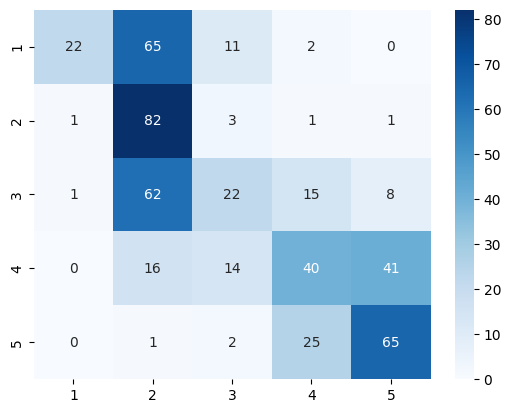

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = all_preds.copy()
y_pred = y_pred.round().astype(int).squeeze()
y_pred[y_pred>5] = 5
cm = confusion_matrix(y_test.values, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(min(y_pred), max(y_pred)+1), yticklabels=range(min(y_test), max(y_test)+1))
print(classification_report(y_test.values, y_pred))

(0.0, 6.0)

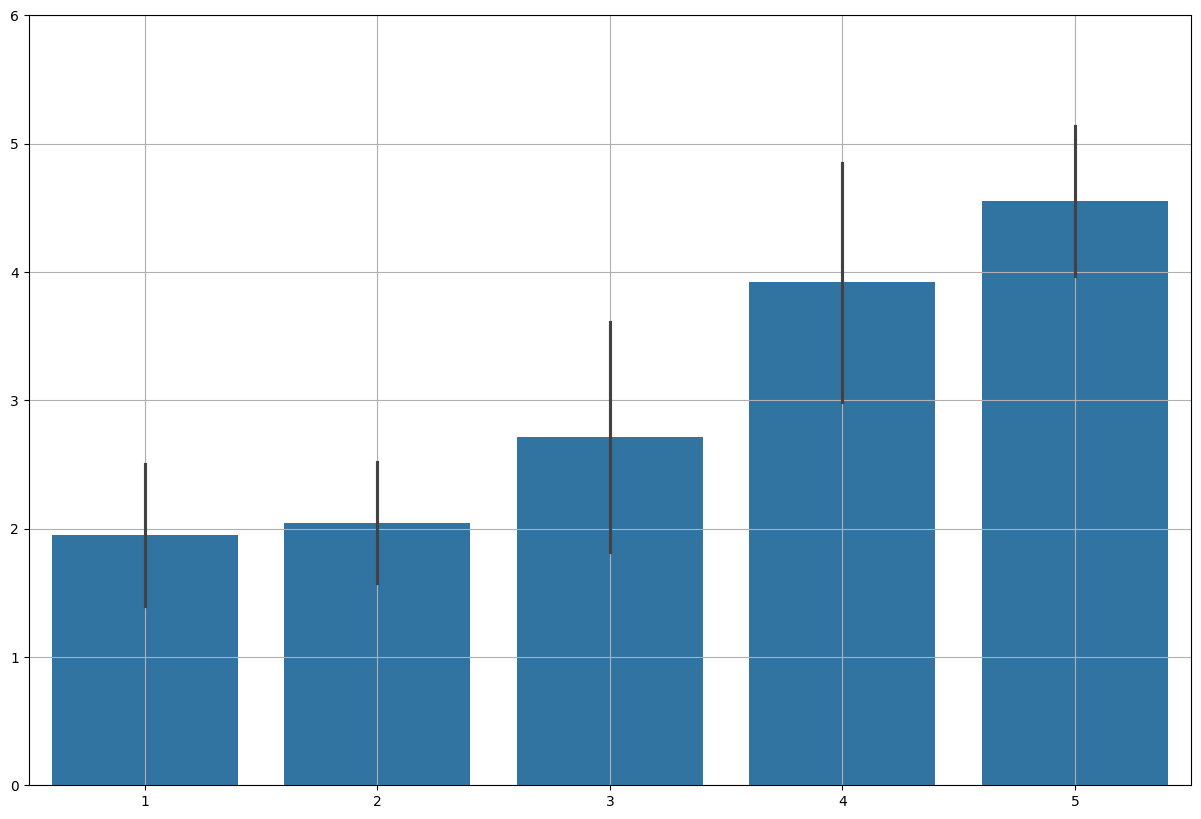

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
sns.barplot(x=y_test.values, y=all_preds.squeeze(), errorbar="sd")
plt.grid()
plt.ylim(0,6)

d:\Steffen\Documents\DL_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Steffen\Documents\DL_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Steffen\Documents\DL_project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.97      0.85      0.90       100
           2       0.54      0.92      0.68        88
           3       0.66      0.35      0.46       108
           4       0.63      0.28      0.39       111
           5       0.57      0.91      0.70        93
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.64       500
   macro avg       0.42      0.41      0.39       500
weighted avg       0.68      0.64      0.62       500



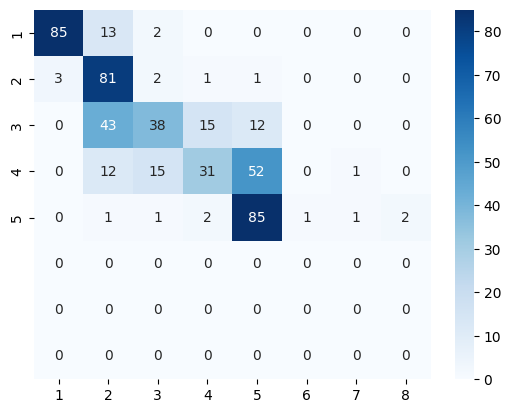

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_test = y_pred_test.round().astype(int)
y_pred_test[y_pred_test < 1] = 1
cm = confusion_matrix(y_test.values, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(min(y_pred_test), max(y_pred_test)+1), yticklabels=range(min(y_test), max(y_test)+1))
print(classification_report(y_test.values, y_pred_test))

In [34]:
# model._save_to_state_dict("model_reg_10000_classes_2_bathsize.pth")
torch.save(model.state_dict(), f"model_reg_{max_per_class}_classes_{batch_size}_bathsize.pth")

In [ ]:
# Test de commentaires prédit avec une note pour une certaine note réelle
mask = (y_pred == 3) & (y_test == 5)
print(x_test[mask]["text"].values)

['Needed a mattress and ordered in less than 10 minutes ']
